In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import regularizers

In [2]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.legend()
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, indices, tit):
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color='blue')
    else:
        plt.plot(train_s.index, train_s, label='Train', color='blue')
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=5),   train_s.index.union(indices)[::5], rotation=60)

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test):
    modelo = Sequential()
    neurons= X_train.shape[1]
    modelo.add(LSTM(X_train.shape[1] * X_train.shape[2], 
                   activation='relu',
                   return_sequences=True, 
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(50, 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(25, 
                   activation='relu',
                   return_sequences=False))
    modelo.add(Dropout(0.2))
    #modelo.add(Dense(5, activation='relu'))
    modelo.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.01)))
    modelo.compile(optimizer='rmsprop', loss='mean_squared_error')
    modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)
    
    return modelo
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse


In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_final.csv', header=0)
datos_Tenerife = datos[datos['isla'] == 'TENERIFE']

datos_Tenerife = datos_Tenerife.set_index('fecha') # Asignamos la fecha como índice

In [4]:
# Variables globales a utilizar en todo el proceso

variables_covid = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']    # Atributos para el análisis de las variables pandémicas
variables_atm = ['tmin', 'tmed', 'presMax']                            # Atributos para el análisis de las variables atmosféricas
variables = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables

objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10      # días a predecir y a agrupar para cada predicción
isla = 'Tenerife'         # Isla a la que se está realziando el estudio
fechas = datos_Tenerife.tail(dias_prediccion).index # Fechas de los días a predecir

In [5]:

# Cargamos los datos de cada estudio con sus atributos correspondientes
datos_Tenerife_uni = datos_Tenerife[objetivo]
datos_Tenerife_uni_arr = np.array(datos_Tenerife_uni).reshape(-1, 1)

datos_Tenerife_mult_covid = datos_Tenerife[[objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']]
datos_Tenerife_mult_atm = datos_Tenerife[[objetivo, 'tmin', 'tmed', 'presMax']]
datos_Tenerife_mult_total = datos_Tenerife[[objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax']]

# Red Neuronal Recurrente univariable

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_uni_scaled = scaler.fit_transform(datos_Tenerife_uni_arr)

In [7]:
n_train = len(datos_Tenerife_uni_scaled) - dias_prediccion


train = datos_Tenerife_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_uni_scaled[n_train - dias_prediccion:len(datos_Tenerife_uni_scaled), :]

In [8]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50


C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0427 - val_loss: 0.0250
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0437 - val_loss: 0.0248
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0434 - val_loss: 0.0243
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0355 - val_loss: 0.0218
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0389 - val_loss: 0.0217
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0351 - val_loss: 0.0209
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0400 - val_loss: 0.0208
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0358 - val_loss: 0.0194
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0348 - val_loss: 0.0181
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0288 - val_loss: 0.0182
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0285 - val_loss: 0.0166
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0249 - val_loss: 0.0161
Epoch 13/50

In [10]:
test_pred = modelo.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


In [11]:
y_pred

array([[764.619  ],
       [720.70514],
       [674.86584],
       [616.5827 ],
       [654.4083 ],
       [717.3852 ],
       [638.73926],
       [554.76697],
       [499.27597],
       [482.49808]], dtype=float32)

In [12]:
y_test

array([[269.],
       [193.],
       [636.],
       [760.],
       [716.],
       [607.],
       [636.],
       [266.],
       [163.],
       [319.]])

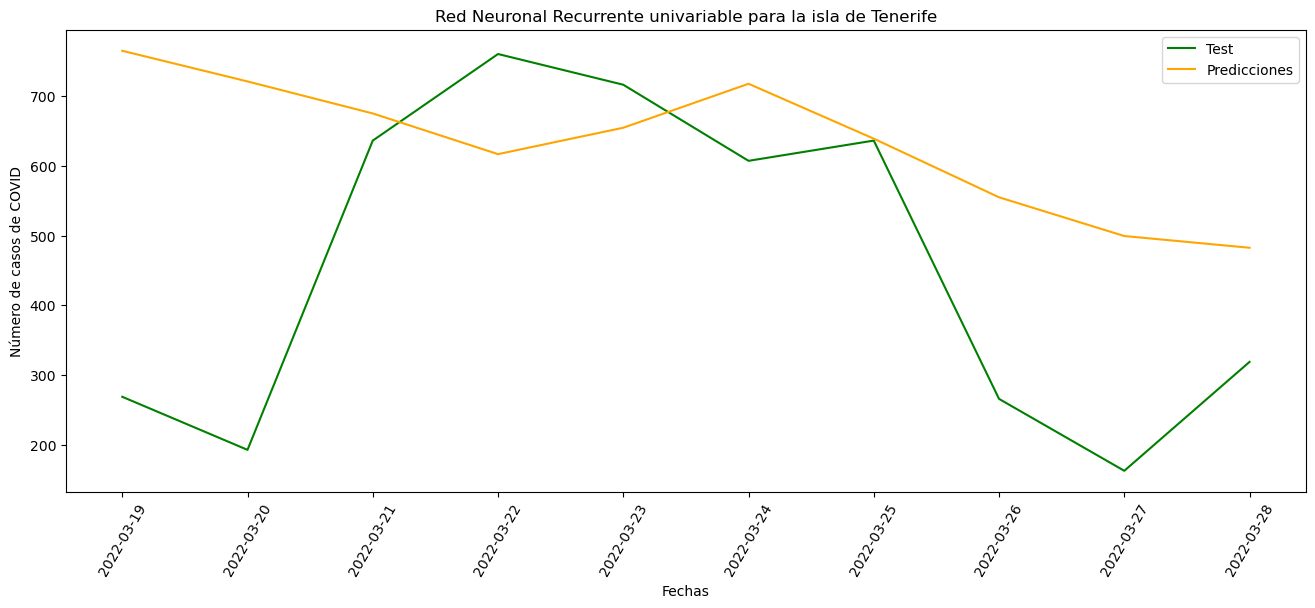

In [13]:
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

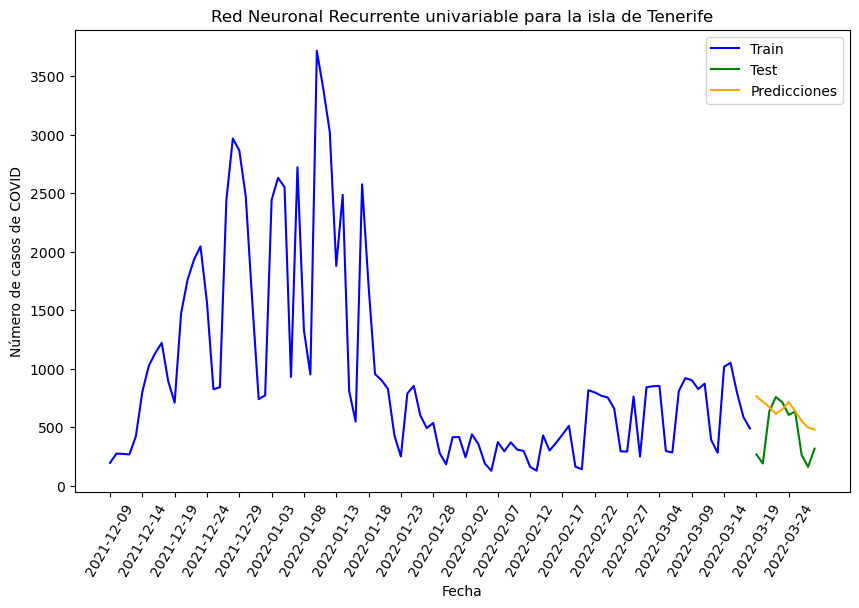

In [14]:
datos_train = datos_Tenerife_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',100,fechas,tit)

In [15]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 78537.54405585137
Error absoluto medio (MAE) del modelo: 216.88644409179688
Raíz del error cuadrático medio (RMSE) del modelo: 280.24550675408045


# Red Neuronal Recurrente multivariable con variables de pandemia

In [16]:
datos_Tenerife_mult_covid = datos_Tenerife[[objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']]
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_covid_scaled = scaler.fit_transform(datos_Tenerife_mult_covid)

In [17]:
# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_covid[objetivo]).reshape(-1, 1))

In [18]:
n_train = len(datos_Tenerife_mult_covid_scaled) - dias_prediccion


train = datos_Tenerife_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_covid_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_covid_scaled), :]

In [19]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [20]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50


C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.0548 - val_loss: 0.0287
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0443 - val_loss: 0.0253
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0386 - val_loss: 0.0233
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0364 - val_loss: 0.0230
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0341 - val_loss: 0.0213
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0272 - val_loss: 0.0219
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0261 - val_loss: 0.0191
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0253 - val_loss: 0.0185
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0236 - val_loss: 0.0184
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0240 - val_loss: 0.0176
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0241 - val_loss: 0.0165
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0194 - val_loss: 0.0159
Epoch 13/50

In [21]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


In [22]:
y_pred

array([[646.4547 ],
       [625.4623 ],
       [617.1721 ],
       [582.78033],
       [566.5074 ],
       [598.9746 ],
       [574.8049 ],
       [536.7336 ],
       [534.8154 ],
       [577.7168 ]], dtype=float32)

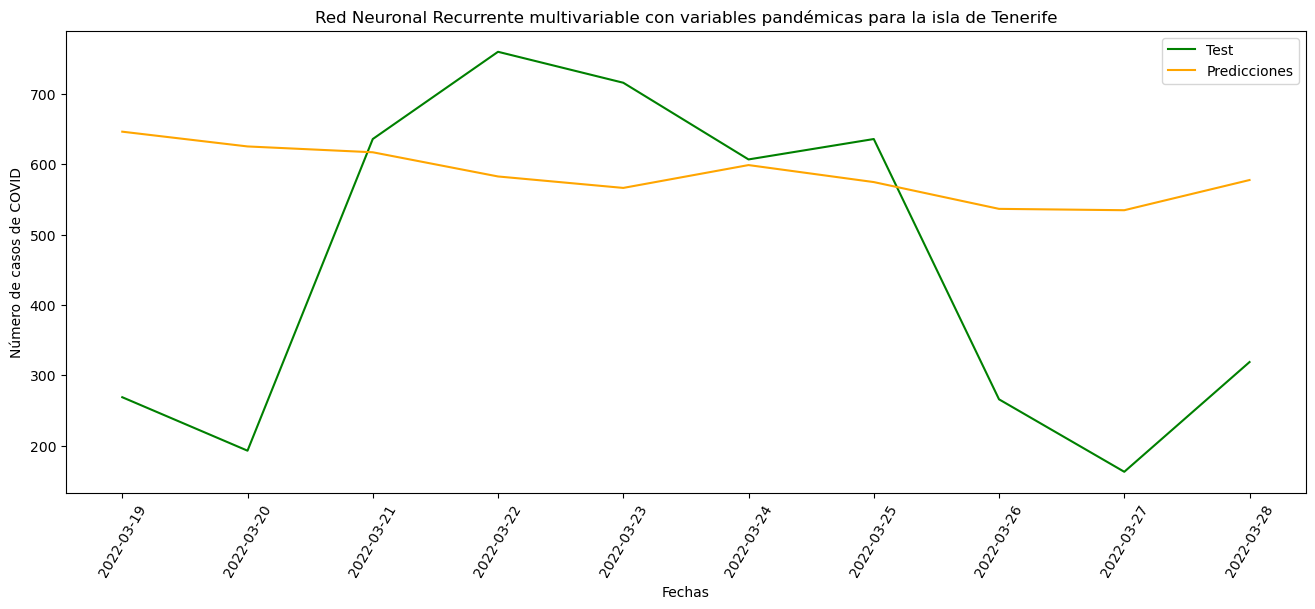

In [23]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

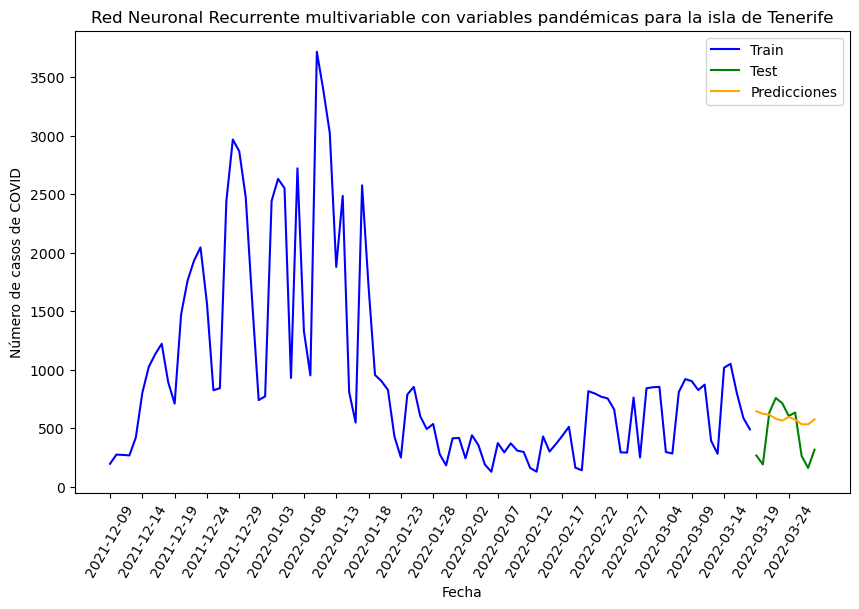

In [24]:
datos_train = datos_Tenerife_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [25]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 66589.20418866724
Error absoluto medio (MAE) del modelo: 212.59434814453124
Raíz del error cuadrático medio (RMSE) del modelo: 258.04884070397844


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_atm_scaled = scaler.fit_transform(datos_Tenerife_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_atm[objetivo]).reshape(-1, 1))

In [27]:
n_train = len(datos_Tenerife_mult_atm_scaled) - dias_prediccion


train = datos_Tenerife_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_atm_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_atm_scaled), :]

In [28]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [29]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50


C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0528 - val_loss: 0.0306
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0418 - val_loss: 0.0267
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0382 - val_loss: 0.0240
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0403 - val_loss: 0.0226
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0363 - val_loss: 0.0213
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0370 - val_loss: 0.0204
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0339 - val_loss: 0.0193
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0281 - val_loss: 0.0193
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0306 - val_loss: 0.0184
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0322 - val_loss: 0.0176
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0252 - val_loss: 0.0171
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0281 - val_loss: 0.0173
Epoch 13/50


In [30]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


In [31]:
y_pred

array([[778.0266 ],
       [741.08514],
       [702.40784],
       [643.2257 ],
       [655.7187 ],
       [683.97577],
       [617.668  ],
       [544.74207],
       [506.24652],
       [496.13507]], dtype=float32)

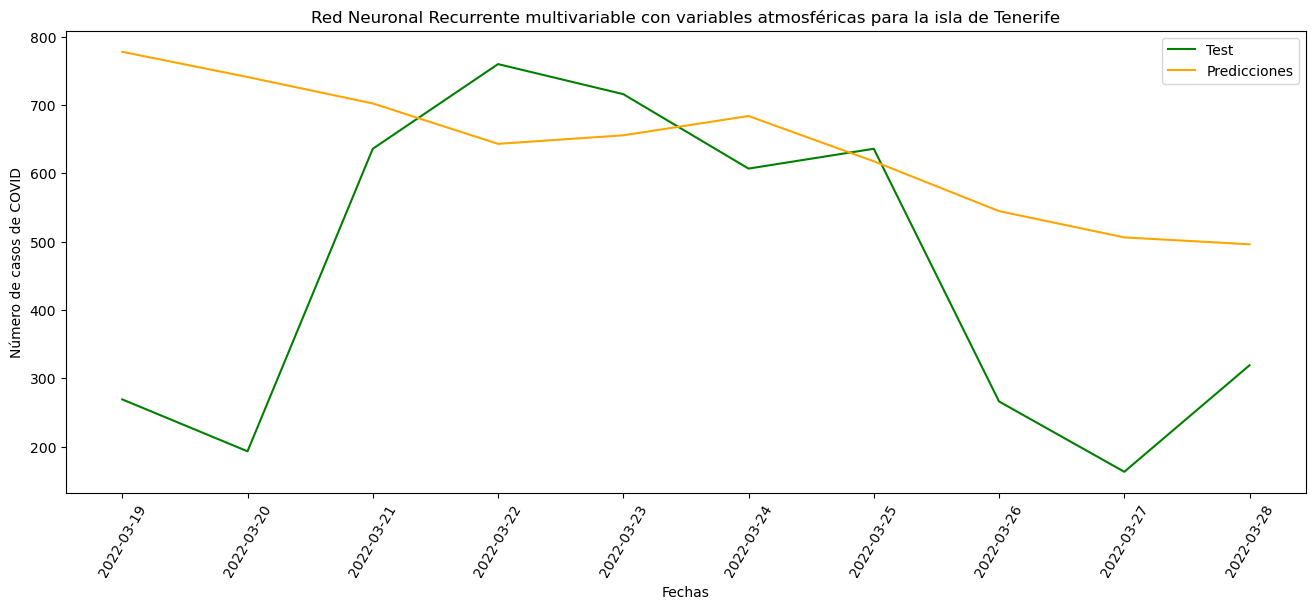

In [32]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

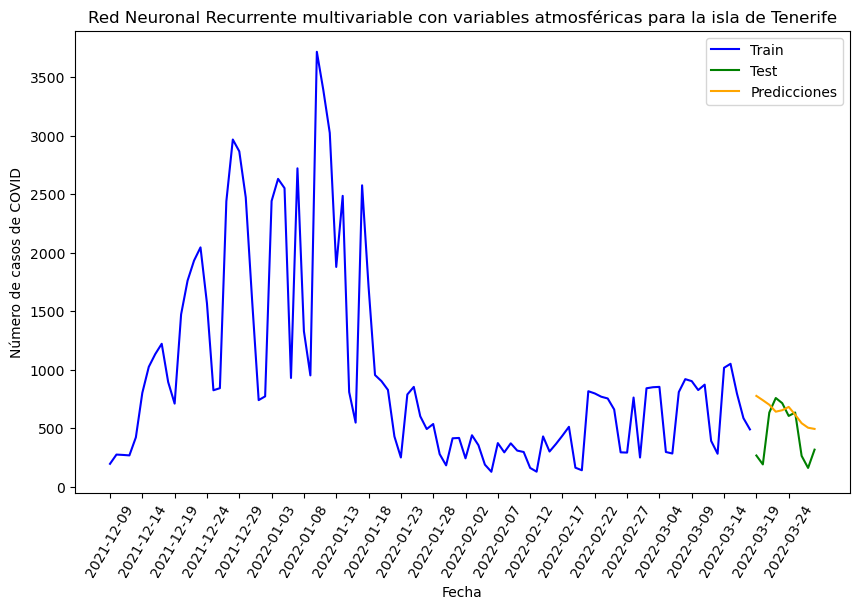

In [33]:
datos_train = datos_Tenerife_mult_atm.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [34]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 81433.89653700366
Error absoluto medio (MAE) del modelo: 219.5006591796875
Raíz del error cuadrático medio (RMSE) del modelo: 285.3662498211792


# Red Neuronal Recurrente multivariable con todas las variables

In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_total_scaled = scaler.fit_transform(datos_Tenerife_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_total[objetivo]).reshape(-1, 1))

In [36]:
n_train = len(datos_Tenerife_mult_total_scaled) - dias_prediccion


train = datos_Tenerife_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_total_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_total_scaled), :]

In [37]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [38]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50


C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.0424 - val_loss: 0.0188
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0361 - val_loss: 0.0179
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0278 - val_loss: 0.0150
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0242 - val_loss: 0.0144
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0229 - val_loss: 0.0138
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0203 - val_loss: 0.0135
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0201 - val_loss: 0.0138
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0211 - val_loss: 0.0152
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0167 - val_loss: 0.0121
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0170 - val_loss: 0.0117
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0163 - val_loss: 0.0119
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0151 - val_loss: 0.0112
Epoch 13/50

In [39]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


In [40]:
y_pred

array([[788.11334],
       [752.6002 ],
       [720.4833 ],
       [662.32196],
       [706.6239 ],
       [761.6187 ],
       [695.58777],
       [619.559  ],
       [566.3661 ],
       [545.87286]], dtype=float32)

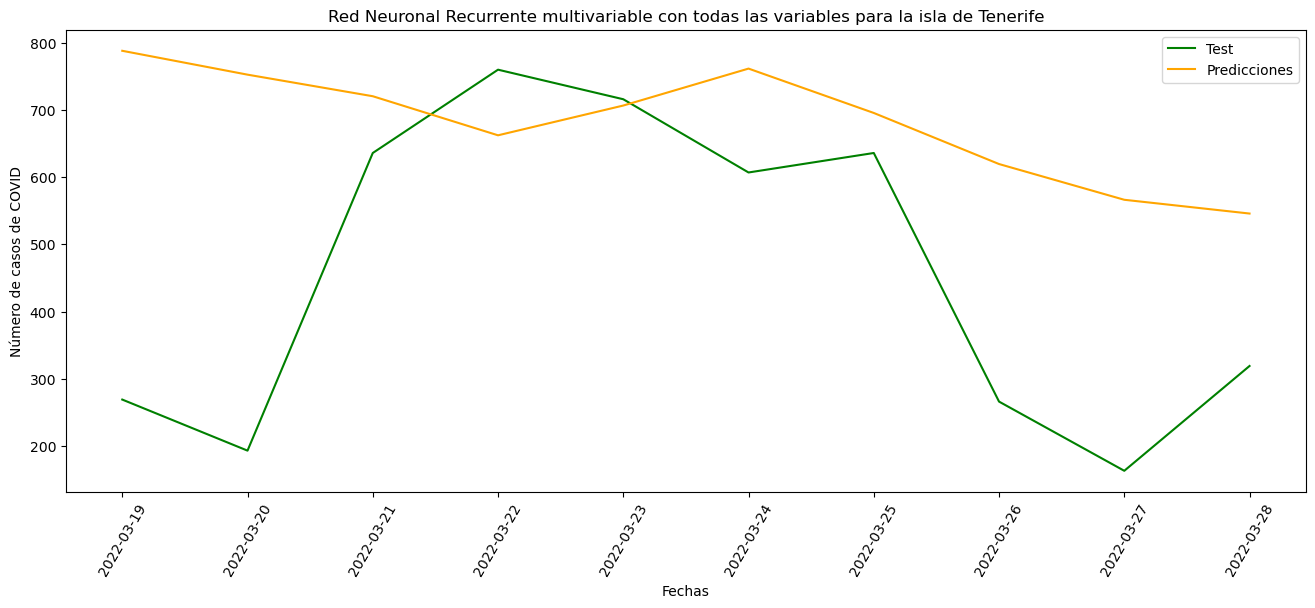

In [41]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

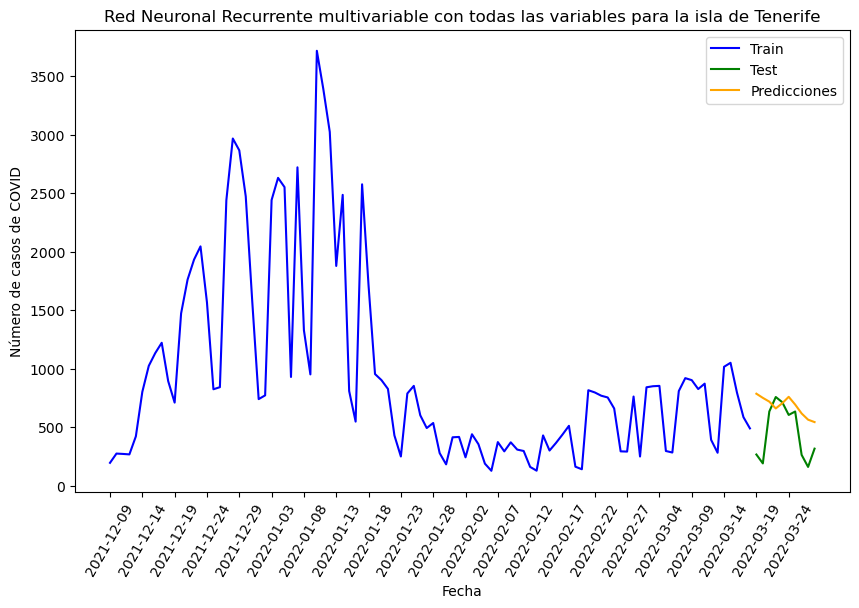

In [42]:
datos_train = datos_Tenerife_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [43]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 96603.45306572653
Error absoluto medio (MAE) del modelo: 246.82554321289064
Raíz del error cuadrático medio (RMSE) del modelo: 310.81096033719035
